In [15]:
def draw_number(pixels):
    plt.figure()
    plt.imshow(pixels)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [11]:
import tensorflow as tf

mnist_raw = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist_raw.load_data()

label_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

x_train = x_train / 255.0
x_test = x_test / 255.0

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Softmax(),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=9)

_, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

SyntaxError: invalid syntax (3980250412.py, line 29)

In [12]:
predictions = model.predict(x_test)

predictions[0]

313/313 [==============================] - 0s 306us/step


array([ -9.5997925 , -12.73954   ,  -2.814871  ,   1.2138853 ,
       -16.646214  ,  -7.9314713 , -20.034403  ,  13.8876505 ,
        -8.48581   ,  -0.46285635], dtype=float32)

Guessing:  7


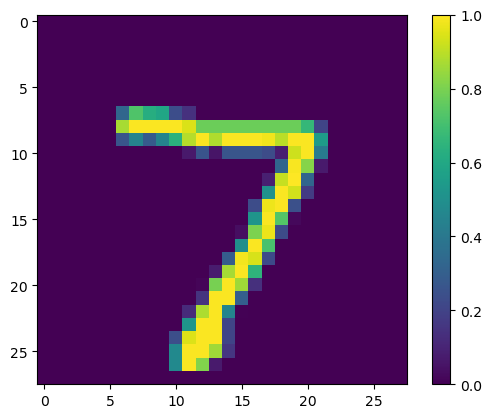

Actual:  7


In [16]:
import numpy as np
import matplotlib.pyplot as plt

print("Guessing: ", np.argmax(predictions[0]))
draw_number(x_test[0])
print("Actual: ", y_test[0])